In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import qiskit
from functools import reduce

In [2]:
def pauli_str_to_unitary(pstr):
    def char_to_pauli(c):
        if c == "I":
            return np.eye(2)
        elif c == "X":
            return np.array([[0, 1], [1, 0]])
        elif c == "Y":
            return np.array([[0, -1j], [1j, 0]])
        elif c == "Z":
            return np.array([[1, 0], [0, -1]])
        else:
            raise ValueError(f"Invalid Pauli character: {c}")
    
    return reduce(np.kron, [char_to_pauli(c) for c in pstr], np.array([[1]]))

In [3]:
def spin_chain_H(n, J=1, g=1, type="transverse"):
    if type == "transverse":
        H = np.zeros((2**n, 2**n))
        for i in range(n):
            if i < n-1:
                pstr = list("I"*n)
                pstr[i] = pstr[i+1] = "Z"
                H += pauli_str_to_unitary(pstr)
            
            pstr = list("I"*n)
            pstr[i] = "X"
            H += g*pauli_str_to_unitary(pstr)

        H *= -J
    return H

In [4]:
def ITE(H, beta):
    return scipy.linalg.expm(-beta * H)

def RTE(H, t):
    return scipy.linalg.expm(-1j * H * t)

In [5]:
def rand_prod_state(n):
    def rand_state():
        return qiskit.quantum_info.random_statevector(2)

    return reduce(np.kron, [rand_state() for _ in range(n)], np.array(1))

def ground_state(H):
    eigenvals, eigenvecs = np.linalg.eigh(H)
    return eigenvecs[:, 0]

In [6]:
def expect(state, H):
    if state.ndim == 1:
        res = state.conj().T @ H @ state
    else:
        rho = state
        res = np.trace(rho @ H)
    
    assert np.isclose(res.imag, 0)
    return res.real # real-valued observables

def outer(state):
    psi = state.reshape(-1, 1)
    return psi @ psi.conj().T

def trdist(rho, sigma):
    return np.sum(np.abs(np.linalg.svdvals(rho-sigma))) / 2

In [7]:
def sample_gcauchy():
    # pdf = lambda u: 1/np.pi * 1/(1+(u/np.sqrt(2))**4)
    thresh = (1+np.sqrt(5))/2 # sup u of pdf(u)/cauchypdf(u) = golden ratio
    while True:
        c = scipy.stats.cauchy.rvs()
        u = scipy.stats.uniform.rvs()
        h = (1+c**2)/(1+(c/np.sqrt(2))**4)
        if u < h/thresh: return c

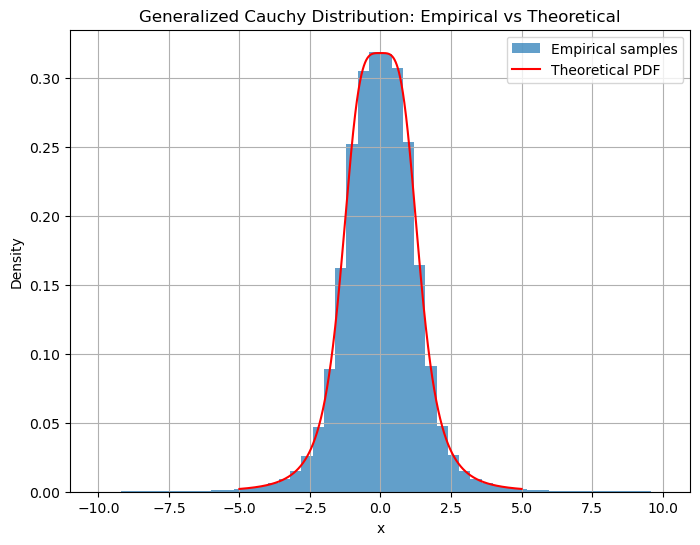

In [8]:
T = int(1e6)
samples = np.array([sample_gcauchy() for _ in range(T)]).flatten()

plt.figure(figsize=(8,6))
x = np.linspace(-5, 5, 1000)
pdf = lambda u: 1/np.pi * 1/(1+(u/np.sqrt(2))**4)

plt.hist(samples[np.abs(samples) <= 10], bins=50, density=True, alpha=0.7, label='Empirical samples')
plt.plot(x, pdf(x), 'r-', label='Theoretical PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Generalized Cauchy Distribution: Empirical vs Theoretical')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
def iITE(state, H, beta):
    psi_ = ITE(H, beta) @ state
    psi = psi_ / np.linalg.norm(psi_)
    return psi

def iITE_rand_iRTE(state, H, beta, M = 1000, distrib="gcauchy"):
    psi = iITE(state, H, beta)
    
    samples = [sample_gcauchy() for _ in range(M)]
    states = [RTE(H, t) @ psi for t in samples]
    rho = sum([outer(s) for s in states]) / M
    return rho

In [11]:
def spin_cov(rho, spin_ind):
    n = int(np.log2(rho.shape[0]))
    pstr = list('I'*n)
    pstr[spin_ind] = 'X'
    expect_Xi = expect(rho, pauli_str_to_unitary(pstr))
    pstr[spin_ind+1] = 'X'
    expect_XiXiplus1 = expect(rho, pauli_str_to_unitary(pstr))
    pstr[spin_ind] = 'I'
    expect_Xiplus1 = expect(rho, pauli_str_to_unitary(pstr))
    spin_cov = expect_XiXiplus1 - expect_Xi*expect_Xiplus1
    return spin_cov

In [12]:
n = 4
H = spin_chain_H(n)
ketlam0 = ground_state(H)

betas = np.linspace(0, 5, 100)
data = {'energies': dict(), 'spincov': dict(), 'spincov2': dict(), 'trd': dict()}

method_names = ['iITE', 'iITE_rand_iRTE']
methods = [lambda *args, **kwargs: outer(iITE(*args, **kwargs)), iITE_rand_iRTE]

psi0 = rand_prod_state(n)
for mi, m in enumerate(methods):
    mn = method_names[mi]
    method = methods[mi]
    d = {k: [] for k in data}
    for beta in betas:
        rho = method(psi0, H, beta)

        d['energies'].append(expect(rho, H))
        d['trd'].append(trdist(rho, outer(ketlam0)))

        d['spincov'].append(spin_cov(rho, n//2-1))
        d['spincov2'].append(spin_cov(rho, n//2))
    
    for k in data:
        data[k][mn] = np.array(d[k])


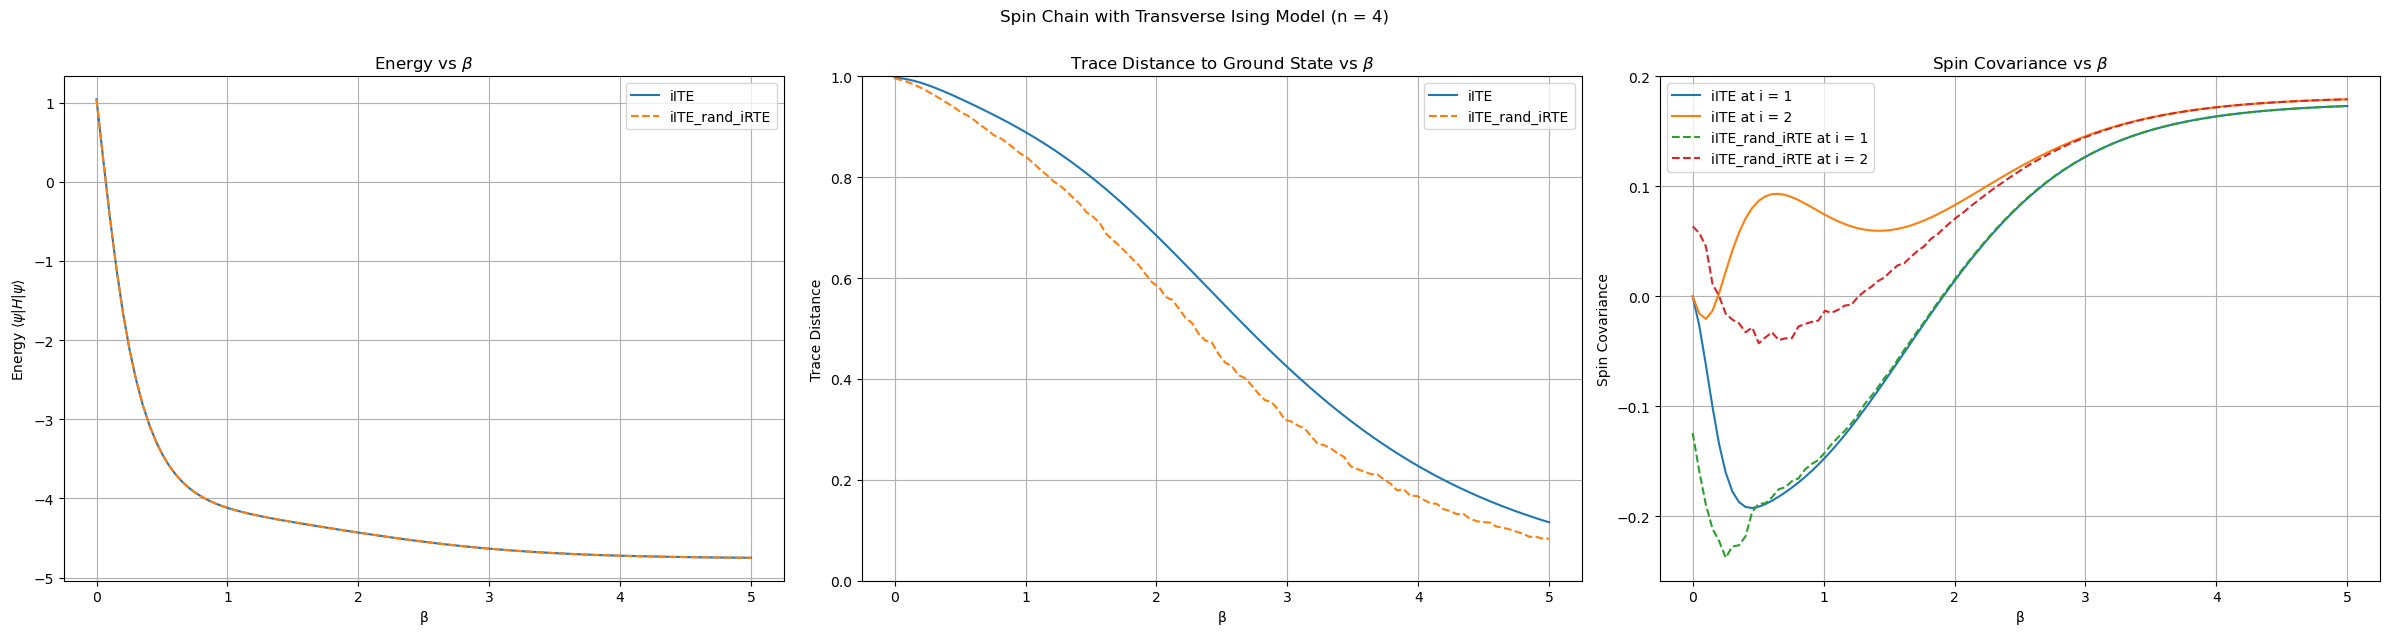

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))

for method in method_names:
    linestyle = '-' if method == 'iITE' else '--'
    ax1.plot(betas, data['energies'][method], linestyle, label=method)
ax1.set_xlabel('β')
ax1.set_ylabel(r'Energy $\langle \psi | H | \psi \rangle$')
ax1.set_title(r'Energy vs $\beta$')
ax1.legend()
ax1.grid(True)

for method in method_names:
    linestyle = '-' if method == 'iITE' else '--'
    ax2.plot(betas, data['trd'][method], linestyle, label=method)
ax2.set_xlabel('β')
ax2.set_ylabel(r'Trace Distance')
ax2.set_title(r'Trace Distance to Ground State vs $\beta$')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True)

for method in method_names:
    linestyle = '-' if method == 'iITE' else '--'
    ax3.plot(betas, data['spincov'][method], linestyle, label=method + f' at i = {n//2-1}')
    ax3.plot(betas, data['spincov2'][method], linestyle, label=method + f' at i = {n//2}')
ax3.set_xlabel('β')
ax3.set_ylabel(r'Spin Covariance')
ax3.set_title(r'Spin Covariance vs $\beta$')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.suptitle(f'Spin Chain with Transverse Ising Model (n = {n})', y=1.05)
plt.show()